# ポアソン-ガウス過程回帰モデル
## モデル
$$
\mathbb{P}(y_i|\lambda(f_i)) = \mathbb{Poisson}(y_i|\lambda(f_i)) = \frac{\lambda(f_i)^{y_i}}{y_i!}e^{-\lambda(f_i)}
$$
ただし，$\lambda(f_i) = \exp(f_i)$である．

$\vec{f}$はガウス過程であるとし，$\vec{f} \sim \mathcal{N}(\vec{0}, K)$とする．

ここで$K$はグラム行列であり，$K_{ij} = k(x_i, x_j)$である．

## 事後分布
事後分布$\mathbb{P}(f^*|\vec{y})$を計算していきたい．
$$
\mathbb{P}(f^*|\vec{y}) = \int \mathbb{P}(f^*|\vec{f})\mathbb{P}(\vec{f}|\vec{y})d\vec{f}
$$

被積分関数の具体的な形はそれぞれ
$$
\mathbb{P}(f^*|\vec{f}) = \mathcal{N}(f^*|\vec{k}_*^{\top}K^{-1}\vec{f}, k_{**} - \vec{k}_*^{\top}K^{-1}\vec{k}_*) \\
\mathbb{P}(\vec{f}|\vec{y}) \propto \mathbb{P}(\vec{y}|f)\mathbb{P}(\vec{f}) 
$$

ここで$\vec{k}_* = (k(x_*, x_1), \cdots, k(x_*, x_n))^{\top}$である．

また，$\mathbb{P}(\vec{y}|f)$はポアソン分布であり，$\mathbb{P}(\vec{f})$はガウス分布である．

この$\mathbb{P}(\vec{f}|\vec{y})$をラプラス近似することにより，事後分布$\mathbb{P}(f^*|\vec{y})$を求めることができる．

### ラプラス近似に計算
$$
\mathbb{P}(\vec{f}|\vec{y}) \propto \mathbb{P}(\vec{y}|f)\mathbb{P}(\vec{f})\\
l(\vec{f}) = \log \mathbb{P}(\vec{f}|\vec{y}) \propto \log \mathbb{P}(\vec{y}|f) + \log \mathbb{P}(\vec{f})
$$
とする．この$l(\vec{f})$を最大化する$\vec{f}$を求める．
$$
\frac{\partial l(\vec{f})}{\partial \vec{f}} = \frac{\partial \log \mathbb{P}(\vec{y}|f)}{\partial \vec{f}} + \frac{\partial \log \mathbb{P}(\vec{f})}{\partial \vec{f}} = 0
$$

反復再重み付け最小二乗法(IRLS)を用いて$\vec{f}$を求めると
$$
\vec{f} = K(\vec{y} - \vec{\lambda})
$$

続いて，ラプラス近似の分散項は
$$
\frac{\partial^2 l(\vec{f})}{\partial \vec{f}^2} = \frac{\partial^2 \log \mathbb{P}(\vec{y}|f)}{\partial \vec{f}^2} + \frac{\partial^2 \log \mathbb{P}(\vec{f})}{\partial \vec{f}^2}
$$
の計算を行うと
$$
\frac{\partial^2 \log \mathbb{P}(\vec{y}|f)}{\partial \vec{f}^2} = -\frac{\partial \vec{\lambda}}{\partial \vec{f}} = -\text{diag}(\vec{\lambda}) \\
\frac{\partial^2 \log \mathbb{P}(\vec{f})}{\partial \vec{f}^2} = -K^{-1}
$$
であることからヘッセ行列が
$$
H = -\frac{\partial^2 l(\vec{f})}{\partial \vec{f}^2} = \text{diag}(\vec{\lambda}) + K^{-1}
$$
であるので，ラプラス近似の分散項は
$$
\text{cov}(\vec{f}|\vec{y}) = H^{-1} = (K^{-1} + \text{diag}(\vec{\lambda}))^{-1}
$$
まとめると，ラプラス近似の結果は
$$
\mathbb{P}(\vec{f}|\vec{y}) = \mathcal{N}(K(\vec{y} - \vec{\lambda}) , (K^{-1} + \text{diag}(\vec{\lambda}))^{-1})
$$

### 事後分布の計算
ラプラス近似より事後分布の被積分関数はガウス分布の積になるから
$$
\mathbb{P}(f^*|\vec{y}) = \int \mathbb{P}(f^*|\vec{f})\mathbb{P}(\vec{f}|\vec{y})d\vec{f} \\
= \int \mathcal{N}(f^*|\vec{k}_*^{\top}K^{-1}\vec{f}, k_{**} - \vec{k}_*^{\top}K^{-1}\vec{k}_*)\mathcal{N}(\vec{f}|K(\vec{y} - \vec{\lambda}) , (K^{-1} + \text{diag}(\vec{\lambda}))^{-1})d\vec{f}
$$
計算すると
$$
\mathbb{P}(f^*|\vec{y}) \simeq \mathcal{N}(f^*|\vec{k}_*^{\top}(\vec{y} - \vec{\lambda}) , k_{**} - \vec{k}_*^{\top}(K^{-1} +\text{diag}(\vec{\lambda}))^{-1} \vec{k}_* )
$$
という近似解が得られる．

## トイデータでの実験

### データの作成
まずは適当なガウス過程を生成する．

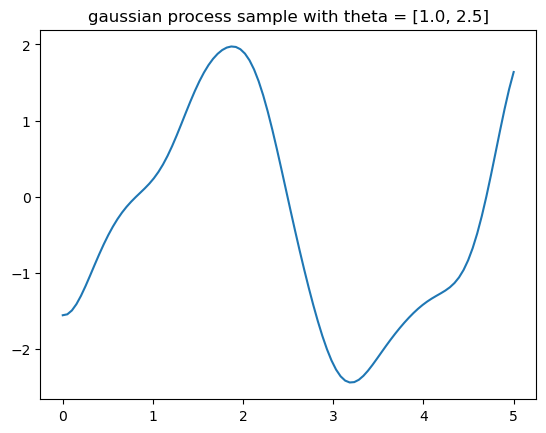

In [1]:
# ガウス過程からのサンプリング
from Gaussian_method import *
import numpy as np
import matplotlib.pyplot as plt

theta = [1.0, 2.5]

# 入力値
X = np.linspace(0, 5, 100)

np.random.seed(123)
samples = sample_gp(X, theta , 3)

# プロット
plt.plot(X, samples[1])
plt.title(f'gaussian process sample with theta = {theta}')
plt.show()

In [2]:
X.shape

(100,)

次にこのガウス過程に対して指数変換を施す．

つまり
$$
\lambda(f_i) = \exp(f_i)
$$
の計算をする

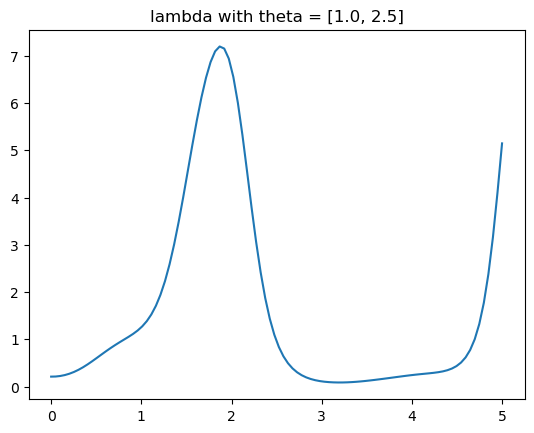

In [3]:
lambda_vec = np.exp(samples[1])
plt.plot(X, lambda_vec)
plt.title(f'lambda with theta = {theta}')
plt.show()

上の$\lambda(t)$は強度関数になる．

この強度関数に従うポアソン分布からサンプリングを行う．

ポアソン分布の分布関数は
$$
\mathbb{P}(y_i|\lambda(f_i)) = \mathbb{Poisson}(y_i|\lambda(f_i)) = \frac{\lambda(f_i)^{y_i}}{y_i!}e^{-\lambda(f_i)}
$$

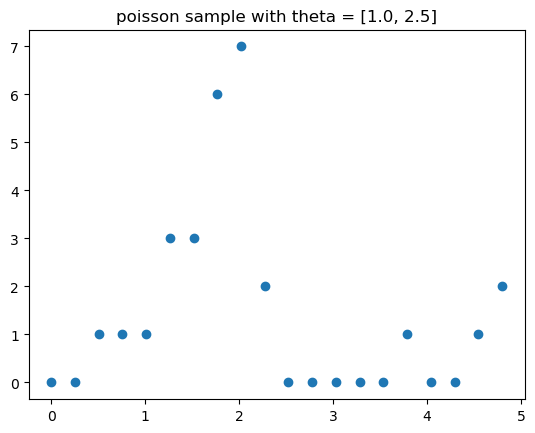

In [4]:
# ポアソン分布からサンプリング
np.random.seed(123)
data = np.random.poisson(lambda_vec)

X_train = X[::5]
y_train = data[::5]
plt.scatter(X_train, y_train)
plt.title(f'poisson sample with theta = {theta}')
plt.show()

### 推定

In [5]:
import GPy

def gpr_poisson(X , Y):
    N = len(Y)
    model = GPy.core.GP(X.reshape(N, 1), Y.reshape(N, 1), kernel=GPy.kern.RBF(1)
                        , likelihood=GPy.likelihoods.Poisson()
                        , inference_method=GPy.inference.latent_function_inference.Laplace())
    model.optimize() # ハイパーパラメータの最適化
    mu , var = model._raw_predict(X.reshape(N, 1))
    return mu , var

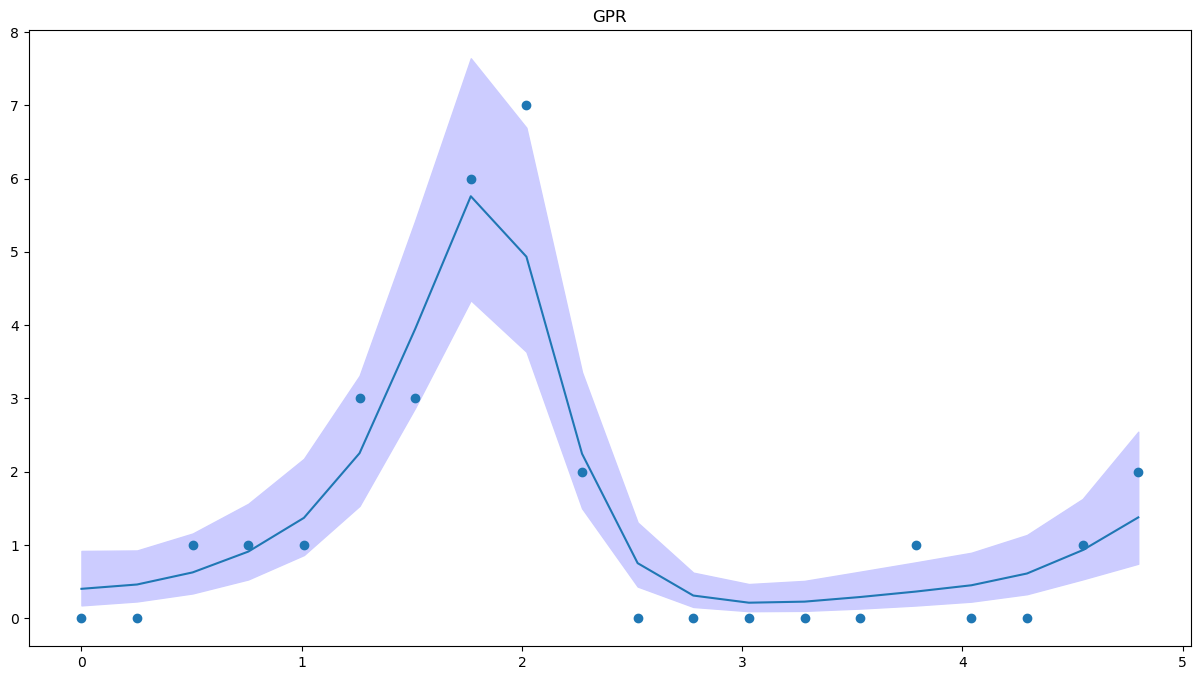

In [6]:
mu , var = gpr_poisson(X_train , y_train)
mu = np.ravel(mu)    # Convert 2D array to 1D
var = np.ravel(var)  # Convert 2D array to 1D

plt.figure(figsize=(15,8))
plt.plot(X_train, np.exp(mu))
plt.fill_between(X_train, np.exp(mu +  np.sqrt(var)), np.exp(mu - np.sqrt(var)) , color = '#ccccff')
plt.scatter(X_train, y_train)
plt.title(f'GPR')
plt.show()

### 他のデータもプロットしてみる

その他のデータも重ねる

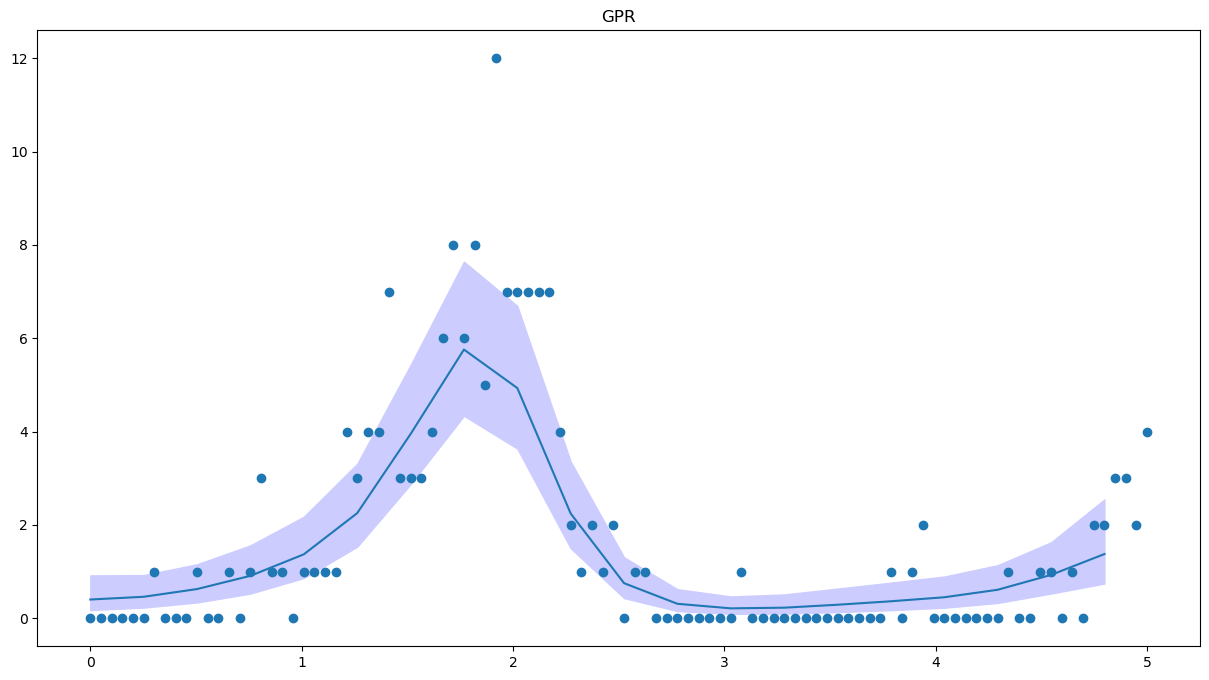

In [7]:
plt.figure(figsize=(15,8))
plt.plot(X_train, np.exp(mu))
plt.fill_between(X_train, np.exp(mu +  np.sqrt(var)), np.exp(mu - np.sqrt(var)) , color = '#ccccff')
plt.scatter(X, data)
plt.title(f'GPR')
plt.show()

### その他のカーネルを使ってみる
https://qiita.com/goldengate94704/items/471a7fec5513e681a138

指数カーネルを試してみる．

まずは指数カーネルをもつガウス過程を眺めてみる

このガウス過程は以下の確率微分方程式の定常状態と一致している
$$
dx = -kx\ dt+ \sqrt{D}\ dW(t)
$$
$$
C_s(\tau) = \frac{D}{2k} \exp{\{-k|\tau|\}}
$$

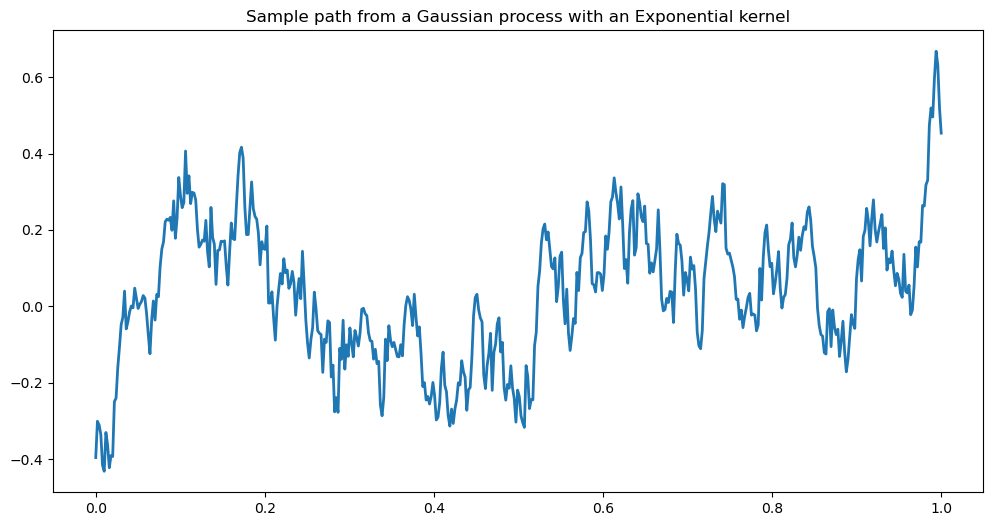

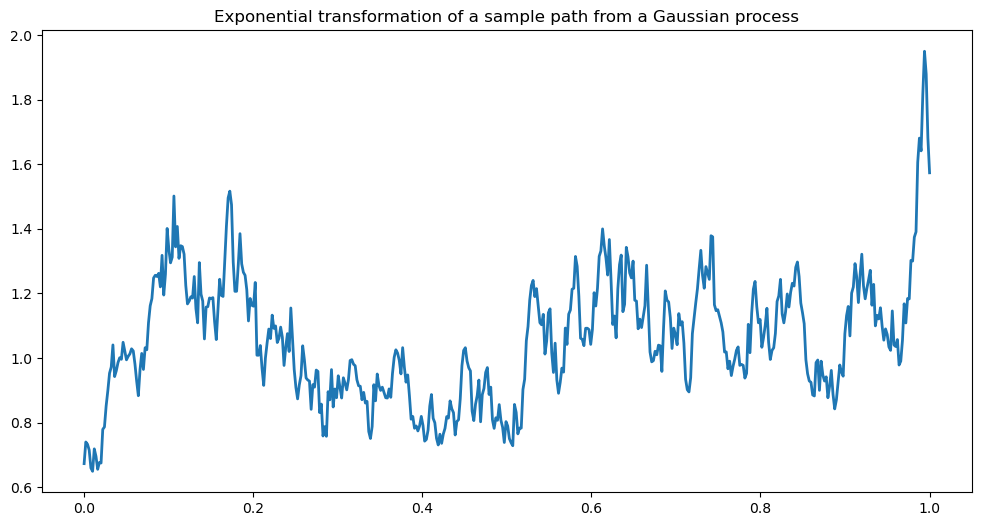

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import GPy

# 入力空間を定義
X = np.linspace(0., 1., 500)[:, None]  # 入力空間の値

# 指数カーネルを定義
kernel = GPy.kern.Exponential(input_dim=1)

# ガウス過程を定義
GP = GPy.models.GPRegression(X, np.zeros((500, 1)), kernel)

# ガウス過程からサンプリング
num_samples = 1  # サンプル数
samples = GP.posterior_samples_f(X, size=num_samples)

# 指数変換
exp_samples = np.exp(samples)

# ガウス過程のサンプルパスをプロット
plt.figure(figsize=(12, 6))
plt.plot(X, samples[:, :, 0], lw=2)
plt.title('Sample path from a Gaussian process with an Exponential kernel')
plt.show()

# 指数変換したサンプルパスをプロット
plt.figure(figsize=(12, 6))
plt.plot(X, exp_samples[:, :, 0], lw=2)
plt.title('Exponential transformation of a sample path from a Gaussian process')
plt.show()


このカーネルを持つと仮定して推定を行った場合の結果をプロットする

In [9]:
def gpr_poisson(X , Y):
    N = len(Y)
    model = GPy.core.GP(X.reshape(N, 1), Y.reshape(N, 1), GPy.kern.Exponential(1)
                        , likelihood=GPy.likelihoods.Poisson()
                        , inference_method=GPy.inference.latent_function_inference.Laplace())
    model.optimize() # ハイパーパラメータの最適化
    mu , var = model._raw_predict(X.reshape(N, 1))
    return mu , var

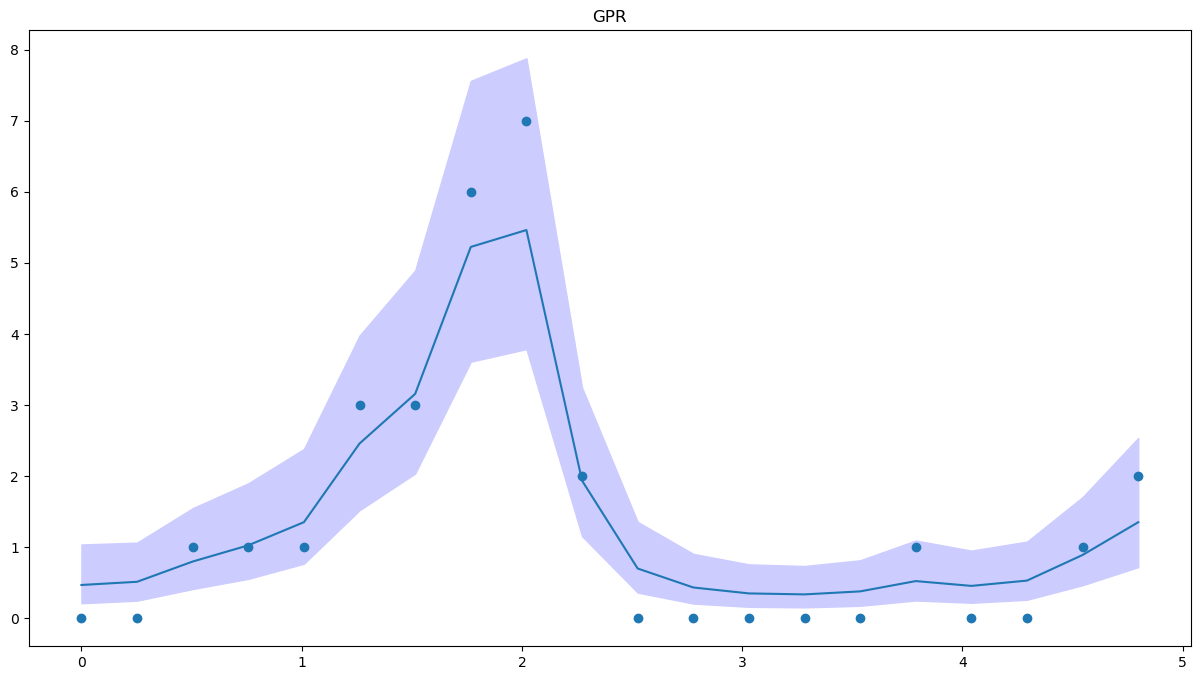

In [10]:
mu , var = gpr_poisson(X_train , y_train)
mu = np.ravel(mu)    # Convert 2D array to 1D
var = np.ravel(var)  # Convert 2D array to 1D

plt.figure(figsize=(15,8))
plt.plot(X_train, np.exp(mu))
plt.fill_between(X_train, np.exp(mu +  np.sqrt(var)), np.exp(mu - np.sqrt(var)) , color = '#ccccff')
plt.scatter(X_train, y_train)
plt.title(f'GPR')
plt.show()

# 参考
## ラプラス近似
### ラプラス近似
連続変数の集合上に定義されている確率変数関数に対して，ガウス分布による近似を見出すことを目的としています．

以下にラプラス近似の流れを説明します．

求めたい分布$p(\vec{x})$として
$$
p(\vec{x}) = \frac{1}{Z} f(\vec{x})
$$
と書けるとします．

まずはピークを見つけます．

つまり
$$
\frac{\partial p(\vec{x}_0)}{\partial \vec{x}} = 0
$$
を満たす$\vec{x}_0$を求めます．

次に，対数を取ってその$x_0$点周りでテイラー展開をします．
$$
\log p(\vec{x}) = \log p(\vec{x}_0) + \frac{1}{2}(\vec{x} - \vec{x}_0)^T \nabla \nabla \log p(\vec{x}_0) (\vec{x} - \vec{x}_0) + \cdots
$$

ここで，$\textbf{A} = - \nabla \nabla \log p(\vec{x}_0)$をヘッセ行列と定義します．

そのヘッセ行列を用いて以下のように近似をします．
$$
p(\vec{x}) \approx \frac{|\textbf{A}|^{1/2}}{2\pi^{M/2}} \exp \left( - \frac{1}{2} (\vec{x} - \vec{x}_0)^T \textbf{A} (\vec{x} - \vec{x}_0) \right)
$$

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# 範囲を定義
x = np.linspace(-np.pi, np.pi, 1000)

# cos関数
f = np.cos(x)

# cos関数の導関数
def df(x):
    return -np.sin(x)

# cos関数の二階導関数
def ddf(x):
    return -np.cos(x)

In [12]:
# ラプラス近似
# x_0は最大値の点（cos関数の場合は0）
x_0 = 0
laplace_approximation = np.cos(x_0) + df(x_0) * (x - x_0) + 0.5 * ddf(x_0) * (x - x_0)**2

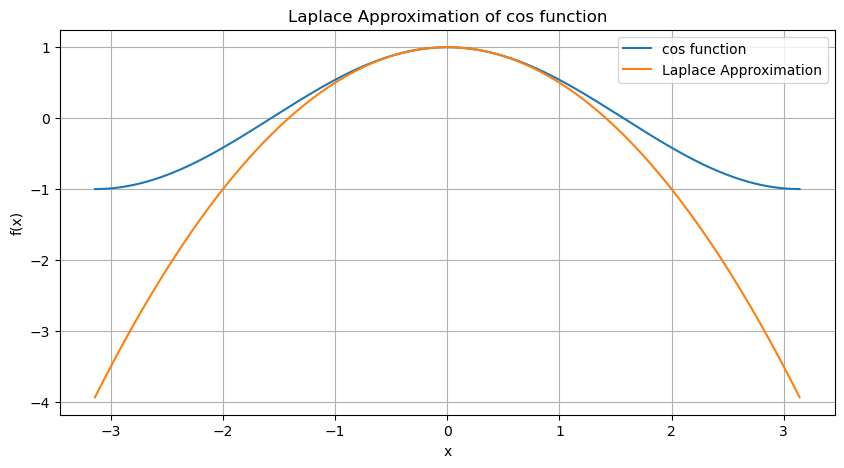

In [13]:
# グラフ描画
plt.figure(figsize=(10, 5))
plt.plot(x, f, label='cos function')
plt.plot(x, laplace_approximation, label='Laplace Approximation')
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Laplace Approximation of cos function')
plt.grid(True)
plt.show()